###### Disclaimer
This project uses public data from Pew Research Center's ["Information Engaged and Information Wary"](http://www.pewinternet.org/dataset/sept-29-nov-6-2016-information-engaged-and-information-wary/) survey.

Pew Research Center bears no responsibility for interpretations presented or conclusions reached based on analysis of the data.

## About
---------------

This notebook explains and implements the technical methodology for generating the insights and recommendations made in the [add link]() [capstone 2 report](http://www.google.com). We recommend first reading the report for a general overview of the problem and the results of analysis.

## Imports and utility functions
---------------

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-muted')

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

def feat_scale(vector):
    '''
    Scale a single vector by to span the range 0-1.
    '''
    return (vector-np.min(vector))/(np.max(vector)-np.min(vector))

## Data Cleaning 
---------------

In [2]:
data = pd.read_csv("../data/September 29 - November 6, 2016 - Information engaged wary - CSV.csv")

# There are is no null data intially.
print(data.isnull().any().any())

#There are some empty strings, which we'll set to int 100 to work with >,< filtering
#Question non-responses are categorized as either 8 or 9, or 98 or99, depending on the question.
#We won't worry about imputing them, seince we later learn that we have enough complete data.
data.replace(r'^\s*$', 100, regex=True, inplace = True)

#These categories had some empty string values.
#All of these are questions that are only asked if another question was true.
null_cats = ['qs1', 'home3nw', 'bbhome1', 'bbhome2', 'device1a', 
 'smart1', 'smart2', 'snsint2', 'q4c', 'q4d', 'q5', 'q6b', 
 'libmob', 'oftvote', 'kidage1', 'race3m2', 'race3m3', 
 'race3m4', 'birth_hisp', 'partyln', 'hh3', 'ql1a', 'qc1']

#So we'll set them to be 'int64', like the other categoricals
null_cats_dict = {i:'int64' for i in null_cats}
data = data.astype(null_cats_dict)

False


## Feature Engineering
---------------

### Dealing with Weighting

Pew surveys include a weight variable intended to scale up or down each response in order to summarically match the general population:

http://www.pewresearch.org/methodology/u-s-survey-research/our-survey-methodology-in-detail/#data-weighting

http://www.applied-survey-methods.com/weight.html

In [3]:
# Create a variable with the weighting normalized for seniors and non-seniors.
# This is specifically for categorically comparing seniors and non-seniors
# directly.

mask = data['age'] >= 65
seniors = data[mask].copy()
non_seniors = data[~ mask].copy()
seniors['senwt'] = 1+seniors['standwt']-seniors['standwt'].mean()
non_seniors['senwt'] = 1+non_seniors['standwt']-non_seniors['standwt'].mean()

senwt = seniors['senwt'].append(non_seniors['senwt'])
senwt = senwt*(len(senwt)/sum(senwt))

data['senwt'] = senwt

### Creating target customer-fit features.

To create our final customer fit score we create a weighted sum of the following.

Note that by giving zero points to non-responses, we assume that they are uniformly distributed across questions and demographics.

###### Technology engagement score (1-10):
Points are given for having engagement with technology.

+1 if uses internet in some way (eminuse)

+1 if owns desktop or laptop computer (device1d)

+1 if home user (home3nw)

+1 if higher speed or both (bbhome)

+1 if social media user (snsint2)

+1 if mobile net user (intmob)

+1 if owns smart phone (smart1 or smart2)

+1 if owns tablet (device1c)

+0 to 2, independence in getting information online (q5)

q5 wording: 1 I do NOT often need help finding the information I need online 2 I could occasionally use some help finding the information I need online, OR 3 I frequently need help finding the information I need online?

###### Time and Attention (1-11):
Points are given for responses indicating more subjective Time and Attention available.

+0 to 3, perception of having time to decide (q9)

q9 wording: Given the things going on in your life, how often do you feel you do NOT have enough time to gather all the information you need for making important decisions? Do you feel this way frequently, sometimes, not too often, or never?

+0 to 3, not multitasker (q7a)

q7a wording: How well does the following statement describe you?
I’m usually trying to do two or more things at once. 

+0 to 3, fast pace not harming health (q7c)

q7c wording: How well does the following statement describe you?
The fast pace of my life feels like it is harming my health.

+0 to 2, 0 for working full time, 1 for part time, 2 for not working (emplnw)

###### Growth Mindset (1-10):

Outlook on Learning

+0,1/3,2/3, or 1, basic intelligence is malleable (q2a)

q2a wording: Please tell me how well this statement describes your views on how people approach learning. People can learn new things, but overall they cannot really change their basic level of intelligence.

+0,1/3,2/3, or 1, music talent can be developed by anyone (q2b)

q2b wording: Please tell me how well this statement describes your views on how people approach learning. Music talent can be developed by anyone. The harder you work at something, the better you will be at it.

+0,1/3,2/3, or 1, the harder you work at something, the better you will be at it (q2c)

q2c wording: Please tell me how well this statement describes your views on how people approach learning. The harder you work at something, the better you will be at it.

+0,1/3,2/3, or 1, truly smart people still must work hard (q2d)

q2d wording: Please tell me how well this statement describes your views on how people approach learning. Truly smart people do not need to try hard.

+0,1/3,2/3, or 1, people are malleable (q2e)

q2e wording: Please tell me how well this statement describes your views on how people approach learning. Each person is a certain kind of person and there is not much that can be done to really change that.

+1 Modern information availability is helpful (q8)

Which of the following statements is closer to your view, even if you do not entirely agree with it?

1 The availability of so much information these days makes it easier for me to make decisions, OR 2 I often feel stressed by the amount of information I need to consider in making decisions. 

Outlook on New Experience 

+1 if trying new things is not stressful (q3a)

+1 if appreciate feedback (q3b)

+1 if gather info to inform choices (q3c)




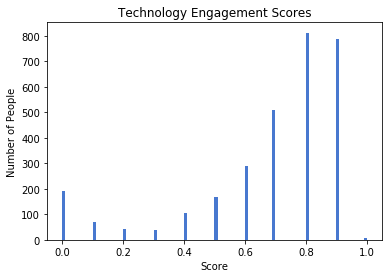

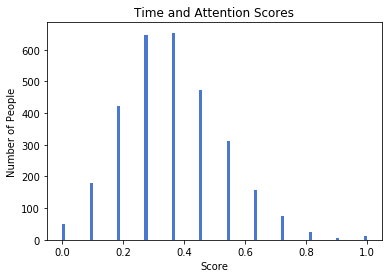

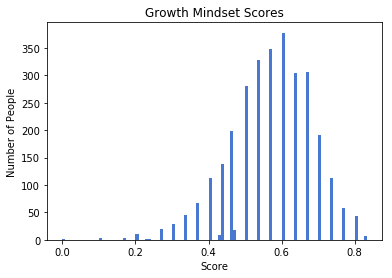

In [26]:
# These functions enable us to convert individual question responses
# into numerical scores we can sum.
def ones_only(x):
    if x == 1:
        return 1
    else:
        return 0
    
def twos_only(x):
    if x == 2:
        return 1
    else:
        return 0
    
def three_scale_flip(x):
    if x > 3:
        return 0
    else:
        return (3-x)

def four_scale_subone(x):
    if x > 4:
        return 0
    else:
        return x-1
    
def four_scale_flip_subone(x):
    if x > 4:
        return 0
    else:
        return 4-x

def emplnw_ize(x):
    if x == 3 or x == 4:
        return 2
    elif x == 2:
        return 1
    else:
        return 0

device_engage = data[['smart1','smart2','home3nw','device1c','eminuse','device1d','bbhome1',
                    'snsint2','intmob']].applymap(ones_only).sum(axis=1).values.reshape(-1)
tech_comfort = data[['q5']].applymap(three_scale_flip).values.reshape(-1)
tech_engage = (device_engage+tech_comfort)
data['tech_engage'] = pd.Series(index=data.index,data=tech_engage,dtype='float64')

not_busy = data[['q9','q7a','q7b']].applymap(four_scale_subone).sum(axis=1).values.reshape(-1)
retired = data[['emplnw']].applymap(emplnw_ize).values.reshape(-1)
time_atten = not_busy+retired

learning_noflip = data[['q2a','q2d','q2e']].applymap(four_scale_subone).sum(axis=1).values.reshape(-1)
learning_flip = data[['q2b','q2c']].applymap(four_scale_flip_subone).sum(axis=1).values.reshape(-1)
learning_bin = data[['q8']].applymap(twos_only).values.reshape(-1)
learning = (learning_flip + learning_noflip + learning_bin)/3
experiences_flip = data[['q3a']].applymap(ones_only).values.reshape(-1)
experiences_noflip = data[['q3b','q3c']].applymap(ones_only).sum(axis=1).values.reshape(-1)
experiences = experiences_flip + experiences_noflip
growth = (learning+experiences)

tech_engage = tech_engage/10
time_atten = time_atten/11
growth = growth/10

#the measures we create are initially skewed
plt.hist(tech_engage,bins=100)
plt.title("Technology Engagement Scores")
plt.xlabel("Score")
plt.ylabel("Number of People")
plt.show()
plt.hist(time_atten,bins=100)
plt.title("Time and Attention Scores")
plt.xlabel("Score")
plt.ylabel("Number of People")
plt.show()
plt.hist(growth,bins=100)
plt.title("Growth Mindset Scores")
plt.xlabel("Score")
plt.ylabel("Number of People")
plt.show()

###### Combining scores to make customer fit

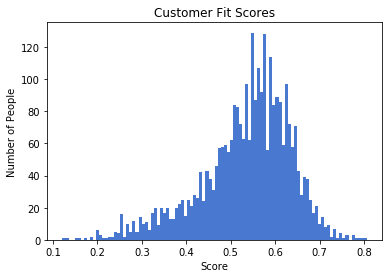

In [27]:
# We apply a slight subjective weighting based on which features we believe to be
# strong predictors.
# This is an entirely speculative guess.
customer_fit = (tech_engage+time_atten+growth)/3.0

plt.hist(customer_fit,bins=100)
plt.title("Customer Fit Scores")
plt.xlabel("Score")
plt.ylabel("Number of People")

#Add these scores to the dataframe.
data['tech_engage'] = pd.Series(index=data.index,data=tech_engage,dtype='float64')
data['time_atten'] = pd.Series(index=data.index,data=time_atten,dtype='float64')
data['growth'] = pd.Series(index=data.index,data=growth,dtype='float64')
data['customer_fit'] = pd.Series(index=data.index,data=customer_fit,dtype='float64')

### Sampling for Complete Demographic Information

Demographics we are interested in:

* Sex 
* Age
* Relationship Status
* Education Level
* Income
* Race
* Political Ideology

Employment is not a covariate because it is part of the target. We assume that we are looking for this and will include it in the recommendation.

In [6]:
# We create a mask to exclude repondents who withheld information for each variable
# Sex is inferred, therefore is present for all respondents

age_mask = data['age'] < 98
marital_mask = data['marital'] < 8
educ2_mask = data['educ2'] < 98
race_mask = data['race3m1'] < 8
inc_mask = data['inc'] < 98
ideo_mask = data['ideo'] < 8

comp_data = data[mask & inc_mask & age_mask & marital_mask & race_mask & educ2_mask & ideo_mask]
part_data = data[mask & age_mask & marital_mask & race_mask & educ2_mask & ideo_mask]

demo_mask = mask & age_mask & marital_mask & race_mask & educ2_mask & ideo_mask

print(len(comp_data)/len(data[mask]))
print(len(part_data)/len(data[mask]))


0.7509677419354839
0.8864516129032258


We have complete demographic data, including income, for 75% (530/707) seniors.

We have complete demographic data, excluding income, for 89% of senior respondents (627 out of 707).

We'll move forward with modeling using the larger complete subset, since income likely can not be measured and actioned upon directly. We will, however, keep the income variable handy for correlation analysis.

Is this subset biased? Let's see if it differs substantially from the set of all seniors sampled.

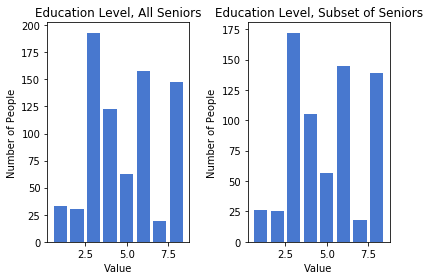

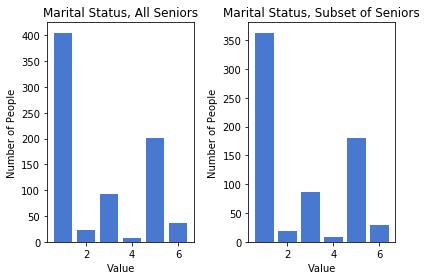

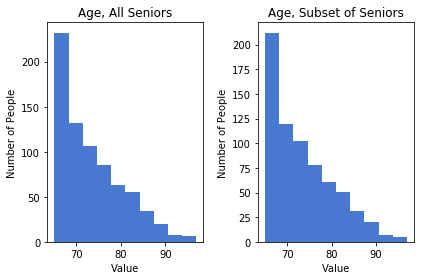

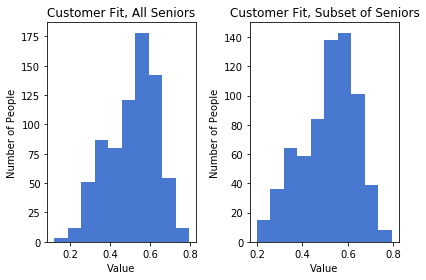

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2)

grp = data[mask & educ2_mask].groupby('educ2')['sample'].count()
ax1.bar([1,2,3,4,5,6,7,8],grp)
ax1.set_title("Education Level, All Seniors")
ax1.set_xlabel("Value")
ax1.set_ylabel("Number of People")

grp2 = data[demo_mask].groupby('educ2')['sample'].count()
ax2.bar([1,2,3,4,5,6,7,8],grp2)
ax2.set_title("Education Level, Subset of Seniors")
ax2.set_xlabel("Value")
ax2.set_ylabel("Number of People")

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
grp = data[mask & marital_mask].groupby('marital')['sample'].count()
ax1.bar(grp.index,grp)
ax1.set_title("Marital Status, All Seniors")
ax1.set_xlabel("Value")
ax1.set_ylabel("Number of People")

grp2 = data[demo_mask].groupby('marital')['sample'].count()
ax2.bar(grp2.index,grp2)
ax2.set_title("Marital Status, Subset of Seniors")
ax2.set_xlabel("Value")
ax2.set_ylabel("Number of People")

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(data[mask & age_mask]['age'])
ax1.set_title("Age, All Seniors")
ax1.set_xlabel("Value")
ax1.set_ylabel("Number of People")

ax2.hist(data[demo_mask]['age'])
ax2.set_title("Age, Subset of Seniors")
ax2.set_xlabel("Value")
ax2.set_ylabel("Number of People")

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(data[mask & age_mask]['customer_fit'])
ax1.set_title("Customer Fit, All Seniors")
ax1.set_xlabel("Value")
ax1.set_ylabel("Number of People")

ax2.hist(data[demo_mask]['customer_fit'])
ax2.set_title("Customer Fit, Subset of Seniors")
ax2.set_xlabel("Value")
ax2.set_ylabel("Number of People")

plt.tight_layout()
plt.show()

The distributions for several of our variables of interest
for our chosen subset and the sample of all seniors who disclosed information for that variable are similar.

This means that it's likely that are sampling hasn't introduced a great deal of selection bias.


### Transforming Demographic Features for Analysis

Now let's work our categorical variables into features that are one of these:

1. Ordinal variables that work in a rank order such as lowest to highest and can be assumed to be "evenly spaced." The evenly spaced assumption is important for linear regression.

2. Indicator variables that work as a binary switch (yes/no, on/off). Categoricals that have multiple values but are not ordinal are given a "one hot" encoding. In this case, a single possibility that is logically implied by all others equaling zero is excluded- preventing redundant information in regression.

3. Continuous quantities.

In [8]:
#Age is a continuous quantity already, more or less.

#Gender is a indicator where 0 = male and 1 = female.
data['is_female'] = data['sex'].astype('float64')-1

#Let's make marital status into an indicator. 0 = no relationship. 1 = domestic relationship.
data['rel_status'] = (data[marital_mask]['marital'] < 3).astype('float64')

#Let's try to create a scale for education that has a more or less linear effect.
def parse_educ(x):
    #high school incomplete
    if x == 1:
        return 0
    #some high school or high school complete
    if x == 2 or x ==3:
        return 1
    # some college or 2 year degree
    if x == 4 or x == 5:
        return 2
    # four year degree or higher
    if x == 6 or x == 7 or x == 8:
        return 3
    return np.nan

data['educ'] = data[educ2_mask][['educ2']].applymap(parse_educ).astype('float64')

# We can't use income as predictor in X, but we are interested in it's effects. 
# The income categories increase in increments of $10,000, which is linear!
def parse_inc(x):
    #income levels
    if x < 9:
        return x-1
    return np.nan
data['income'] = data[['inc']].applymap(parse_inc).astype('float64')

# Let's encode race as 6 indicators and an implicit 7th category for responses of "other".
ohe = OneHotEncoder(sparse=False)
races = ohe.fit_transform(data['race3m1'].values.reshape(-1,1))
data['is_white'] = races[:,0]
data['is_black'] = races[:,1]
data['is_asian'] = races[:,2]
data['is_nat_amer'] = races[:,4]
data['is_pac_isl'] = races[:,5]
data['is_hisp'] = races[:,6]
data.loc[~race_mask,['is_white','is_black','is_asian','is_nat_amer','is_pac_isl','is_hisp']] = np.nan

# Previous EDA demonstrated that if idealogy has an effect, it is not ordinal.
# Moderate will be the category implied by all zeros.
ohe2 = OneHotEncoder(sparse=False)
ideos = ohe2.fit_transform(data['ideo'].values.reshape(-1,1))
data['is_very_con'] = ideos[:,0]
data['is_con'] = ideos[:,1]
data['is_lib'] = ideos[:,3]
data['is_very_lib'] = ideos[:,4]
data.loc[~ideo_mask,['is_very_con','is_con','is_lib','is_very_lib']] = np.nan

# To make analysis easier, let's make sub-sets of the columns of the data
# X_Reg is all of our covariates for regression analysis.
X_reg = data[demo_mask][['age','is_female','rel_status',
                    'educ',
                    'is_white','is_black','is_asian','is_nat_amer','is_pac_isl','is_hisp',
                    'is_very_con','is_con','is_lib','is_very_lib']]

# We add a constant to the dataframe for regression
X_reg = sm.add_constant(X_reg)

# After running OLS regression and choosing covariates with statistically significant 
# relationships, we arrive at this subset of the covariates.
X_reg_short = X_reg[['const','age','is_female','rel_status','educ']]

# We create a version of customer fit scaled such that the minimum and maximum value
# for the relevant sub group of seniors is 0 and 1, respectively.
y = data[demo_mask]['customer_fit']
data['customer_fit_sc'] = feat_scale(y)
y = data[demo_mask]['customer_fit_sc']

#XY_corr includes everything we would like to consider in correlation analysis.
XY_corr = data[demo_mask][['age','is_female','rel_status',
                    'educ','income',
                    'is_white','is_black','is_asian','is_nat_amer','is_pac_isl','is_hisp',
                    'is_very_con','is_con','is_lib','is_very_lib',
                    'tech_engage','time_atten','growth','customer_fit_sc']]


#XY_corr_short distills the most relevant factors
XY_corr_short = XY_corr[['age','is_female','rel_status','educ','income',
                'tech_engage','time_atten','growth','customer_fit_sc']]

In order to group education level, we used violin plots to visually linearize the series of means for tech_engagement.

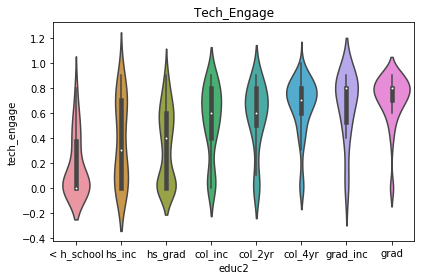

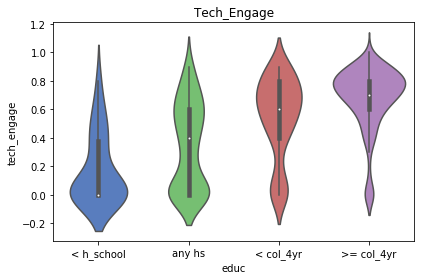

In [9]:
educ2_dict = {
 1: '< h_school',
 2: 'hs_inc',
 3: 'hs_grad',
 4: 'col_inc',
 5: 'col_2yr',
 6: 'col_4yr',
 7: 'grad_inc',
 8: 'grad'
}

educ_dict = {
 0: '< h_school',
 1: 'any hs',
 2: '< col_4yr',
 3: '>= col_4yr',
}

sns.violinplot(data=data[demo_mask],x='educ2',y='tech_engage')
plt.title('Tech_Engage')
plt.xticks(np.array(list(educ2_dict.keys()))-1
           ,list(educ2_dict.values()))
plt.tight_layout()
plt.show()

sns.violinplot(data=data[demo_mask],x='educ',y='tech_engage')
plt.title('Tech_Engage')
plt.xticks(np.array(list(educ_dict.keys()))
           ,list(educ_dict.values()))
plt.tight_layout()
plt.show()

While the means in our grouped education categories look linear, there is greater bi-modality in some categories.

We can now examine a matrix of correlation values to gain intuition about the relationships between variables.

## Exploratory Data Analysis for Customer Fit.

This section deals with exploratory analysis building up to an attempt to predict customer fit based on demographics. There is a second "EDA" section at the end, which deals with comparisons betweens and the general population.

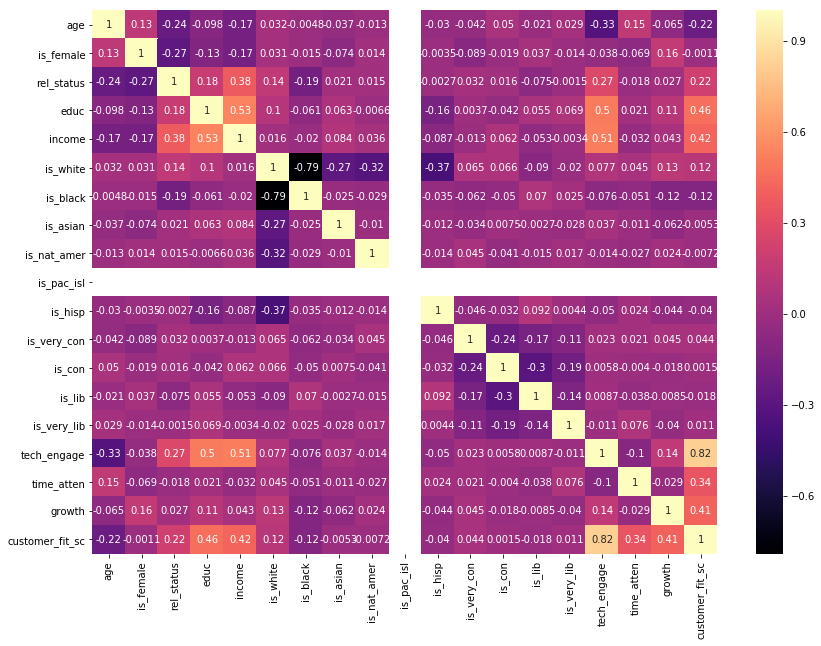

In [10]:
plt.subplots(figsize=(14,10))
inc_mask = data['inc'] < 10
matrix = XY_corr.corr(method='spearman')
sns.heatmap(matrix,annot=True,cmap='magma')
plt.show()

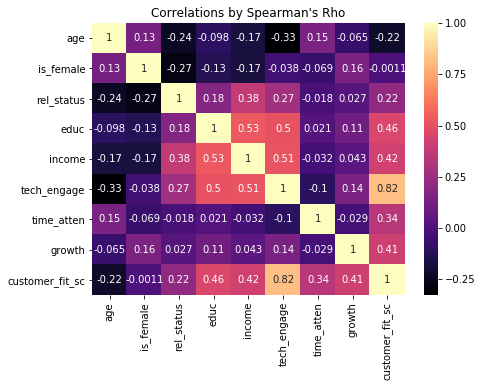

In [11]:
#A smaller picture for the key variables.

plt.subplots(figsize=(7,5))
inc_mask = data['inc'] < 10
matrix = XY_corr_short.corr(method='spearman')
sns.heatmap(matrix,annot=True,cmap='magma')
plt.title("Correlations by Spearman's Rho")
plt.show()

Of particular note:
* Amongst those who reported income, income is highly correlated with tech engagement
* Age is positively correlated with time and attention.
* Time & attention is significantly negatively correlated with tech engagement, possibly via the confounder of age.

The correlation of education to income became important to us in how we framed the final result, which was to focus on marketing to more education, younger seniors.

### Principal Component Analysis

###### Compressing Covariate Feature Space

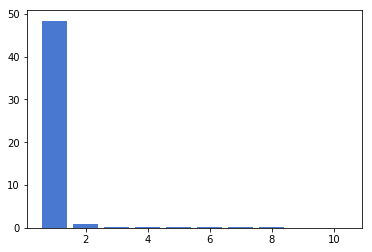

In [12]:
pca = PCA(n_components=10)
pca.fit(X_reg)
plt.bar(np.arange(1,pca.n_components_+1),pca.explained_variance_)
plt.show()

pca = PCA(n_components=8)
pca.fit(X_reg)

X_reg_pca = pca.transform(X_reg)

From PCA we learn that the intrinsic dimensionality of our X feature space is pretty small.
Most of the data can be thought to lie along a "line" of covariance in the feature space.
However, if we want to explain all of it's nuance, we'll need 8 components.

###### Compressing Feature Space of Targets

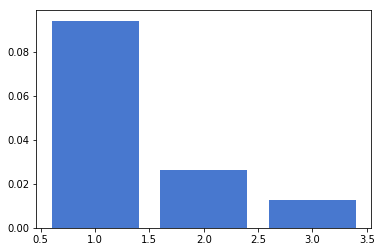

In [13]:
pca2 = PCA(n_components=3)
pca2.fit(XY_corr[['time_atten','growth','tech_engage']])
plt.bar(np.arange(1,pca2.n_components_+1),pca2.explained_variance_)
plt.show()

We see that the targets do covary to some extent, but don't seem to fall on a lower dimensional manifold.

## Regression Analysis for Customer-Fit

In [14]:
# We'll use the PCA'd features to set a maximum R2 we expect to achieve in a linear method 
# with the interpretable model.
X_reg_pca = sm.add_constant(X_reg_pca)
model = sm.OLS(y,X_reg_pca)
result = model.fit()
#Uncomment the summary for the full report.
#result.summary()
print("PCA Features -> Customer Fit, R2 value: {}".format(result.rsquared))

PCA Features -> Customer Fit, R2 value: 0.2903642895868279


Given our features, we don't expect to explain more than 23.56% of the variance in customer fit. This is enough to give us reliable directional insight into the problem.

Now we can proceed to modeling using the interpretable features. We've also selected a subset of the covariates, X_reg_short, based on experimentation and simple feature selection. (Those variables with statistically significant relationships to customer fit were kept.)

In [15]:
tech_model = sm.OLS(data[demo_mask]['tech_engage'],X_reg_short)
tech_model = tech_model.fit(cov_type="HC3")
#print(tech_model.summary())
print("X_reg_short -> Tech Engagment R2 value: {}".format(tech_model.rsquared))

growth_model = sm.OLS(data[demo_mask]['growth'],X_reg_short)
growth_model = growth_model.fit(cov_type="HC3")
#print(growth_model.summary())
print("X_reg_short -> Growth Mindset R2 value: {}".format(growth_model.rsquared))

time_model = sm.OLS(data[demo_mask]['time_atten'],X_reg_short)
time_model = time_model.fit(cov_type="HC3")
#print(time_model.summary())
print("X_reg_short -> Time and Attention R2 value: {}".format(time_model.rsquared),'\n')

cust_fit_model = sm.OLS(y,X_reg_short)
cust_fit_model = cust_fit_model.fit()
print(cust_fit_model.summary())

X_reg_short -> Tech Engagment R2 value: 0.3688212607529274
X_reg_short -> Growth Mindset R2 value: 0.053723862470390515
X_reg_short -> Time and Attention R2 value: 0.025398949937191384 

                            OLS Regression Results                            
Dep. Variable:        customer_fit_sc   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     67.71
Date:                Wed, 23 May 2018   Prob (F-statistic):           2.91e-48
Time:                        21:28:11   Log-Likelihood:                 240.68
No. Observations:                 687   AIC:                            -471.4
Df Residuals:                     682   BIC:                            -448.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef  

## Model Validation

We'll now plot residuals and influence in order to check the model's integrity

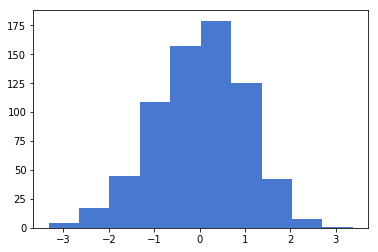

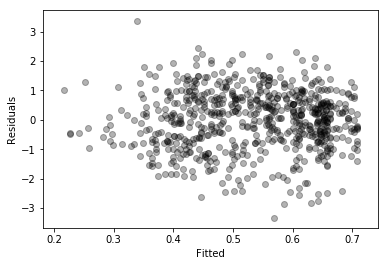

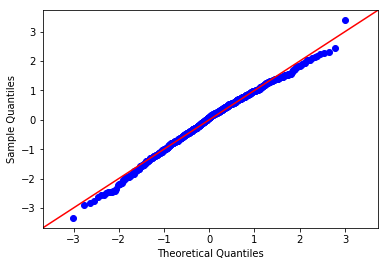

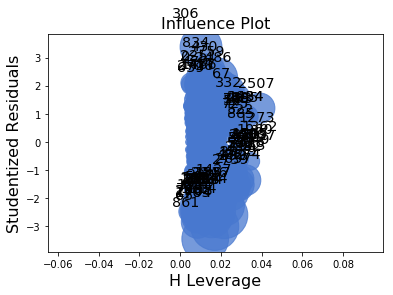

In [16]:
y_hat = cust_fit_model.predict()
y = data[demo_mask]['customer_fit_sc']
residuals = (y-y_hat)
stan_residuals = (residuals-np.mean(residuals))/np.std(residuals)
plt.hist(stan_residuals)
plt.show()
plt.scatter(x=y_hat,y=stan_residuals,alpha=0.3,color='black')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.show()
fig = sm.qqplot(stan_residuals, stats.t, fit=True, line='45')
plt.show()
sm.graphics.influence_plot(result)
plt.show()

Residuals are normally distributed enough to make the conclusions useful in this case.

The plot of residuals to fitted and qq plot show that the conditional distribution of residuals is also in fairly good shape.

The influence plot tells us that there aren't data points with excessive leverage.

We can further explore the relation of the covariates to the target in the below plots

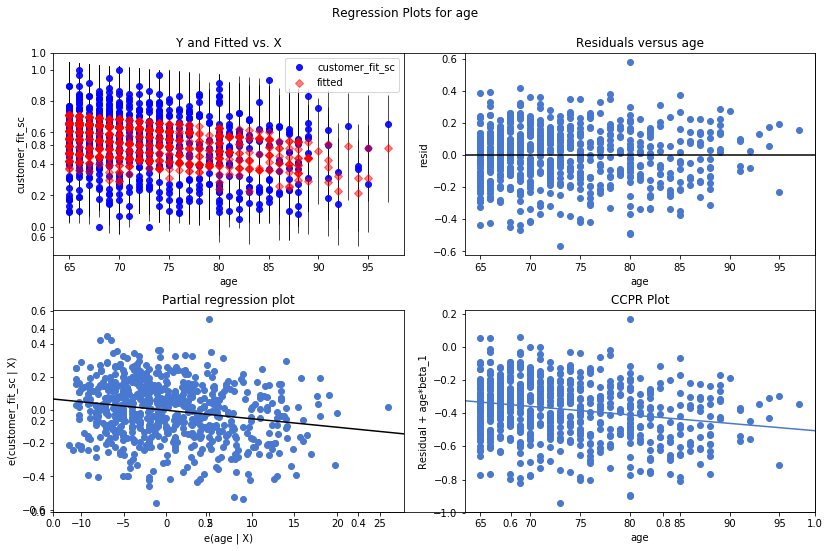

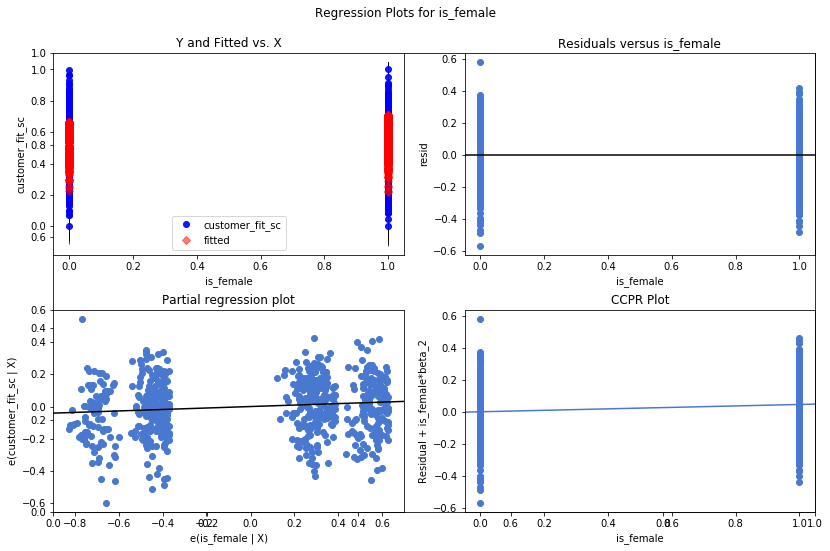

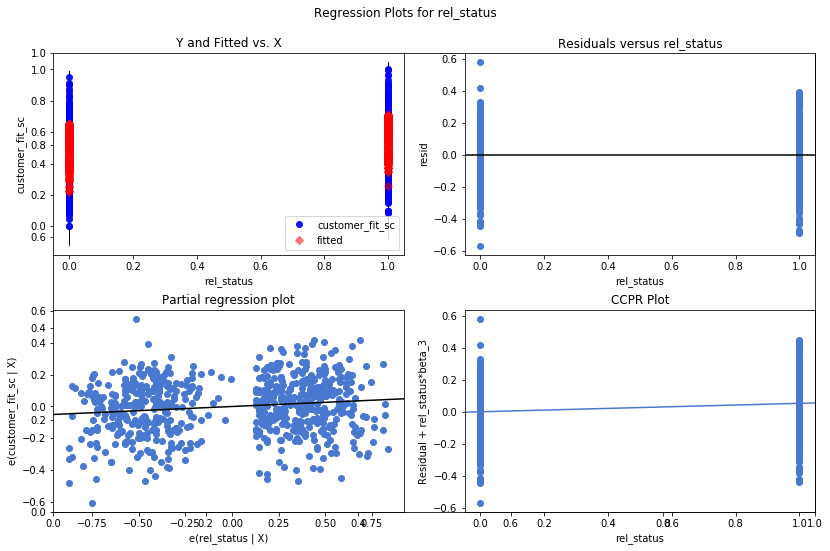

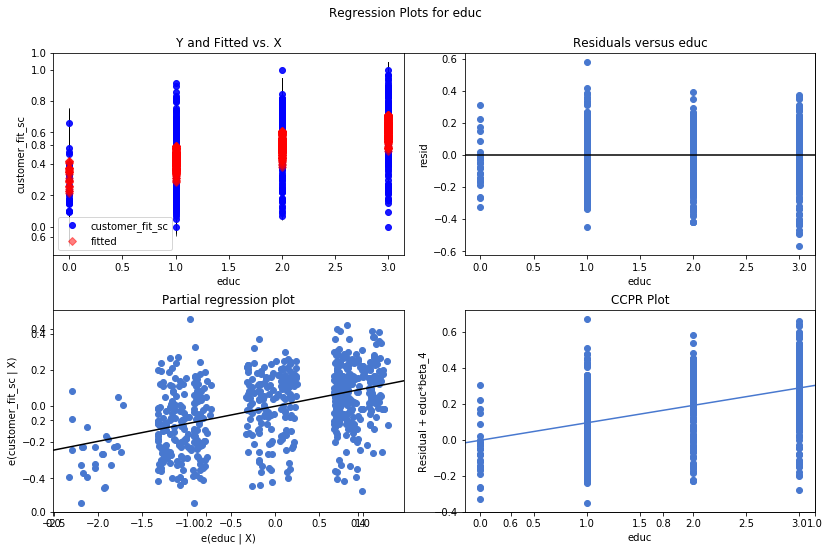

In [17]:
#Diagnostic plots for each covariate.

model = cust_fit_model
for i in ['age','is_female','rel_status','educ']:
    fig, ax = plt.subplots(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(model, i, fig=fig)
    plt.show()

## Visualizing Result

In order to communicate the results of the analysis, we generate nicer versions of the partial regression plots seen above. These plots enable us to isolate the effect of a single covariate in the model.

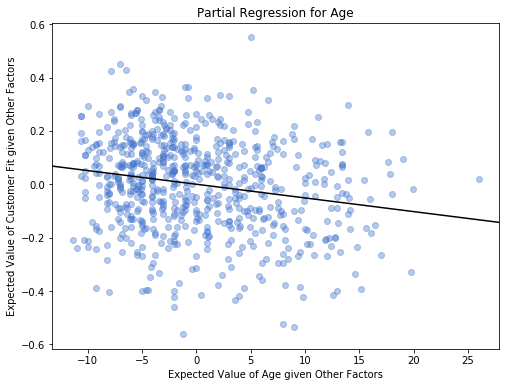

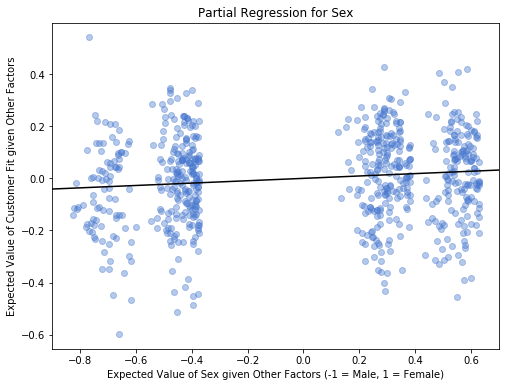

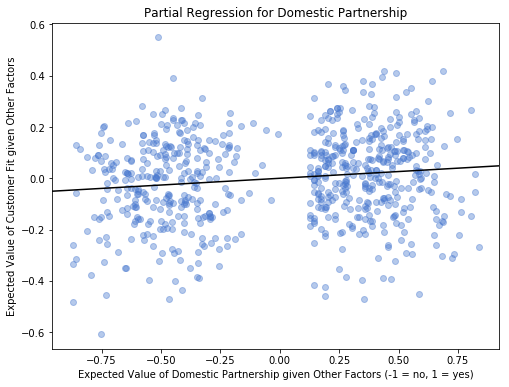

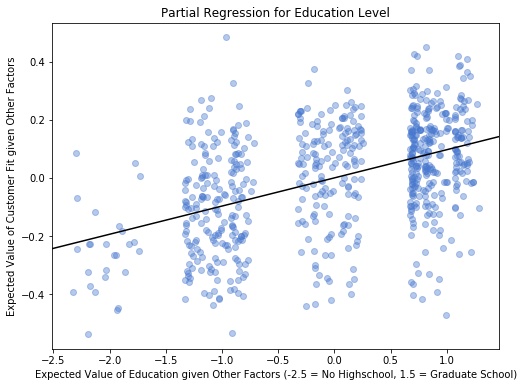

In [18]:
#We'll use added variable plots to show each covariates effect with the others held equal.
#Thanks for added variable plot/partial regression idea: https://stats.stackexchange.com/questions/89747/how-to-describe-or-visualize-a-multiple-linear-regression-model

fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.plot_partregress("customer_fit_sc", "age", ["is_female","rel_status","educ"], 
                                   data=XY_corr, ax=ax,obs_labels=False,alpha=0.4)
plt.xlabel('Expected Value of Age given Other Factors')
plt.ylabel('Expected Value of Customer Fit given Other Factors')
plt.title("Partial Regression for Age")

fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.plot_partregress("customer_fit_sc", "is_female", ["age","rel_status","educ"], 
                                   data=XY_corr, ax=ax,obs_labels=False,alpha=0.4)
plt.xlabel('Expected Value of Sex given Other Factors (-1 = Male, 1 = Female)')
plt.ylabel('Expected Value of Customer Fit given Other Factors')
plt.title("Partial Regression for Sex")

fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.plot_partregress("customer_fit_sc", "rel_status", ["age","is_female","educ"], 
                                   data=XY_corr, ax=ax,obs_labels=False,alpha=0.4)
plt.xlabel('Expected Value of Domestic Partnership given Other Factors (-1 = no, 1 = yes)')
plt.ylabel('Expected Value of Customer Fit given Other Factors')
plt.title("Partial Regression for Domestic Partnership")

fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.plot_partregress("customer_fit_sc", "educ", ["age","is_female","rel_status"], 
                                   data=XY_corr, ax=ax,obs_labels=False,alpha=0.4)
plt.xlabel('Expected Value of Education given Other Factors (-2.5 = No Highschool, 1.5 = Graduate School)')
plt.ylabel('Expected Value of Customer Fit given Other Factors')
_ = plt.title("Partial Regression for Education Level")

## Exploratory Data Analysis for General Insight
---------------

###### There is a smooth decline in the number of seniors by age in the weighted sample.

The small anomaly at 99 corresponds to non responses coded as 98 and 99.

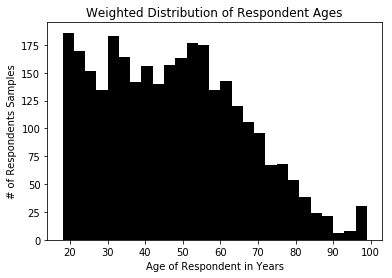

In [19]:
# Need to incorporate weighting into this histogram
plt.hist(data['age'],color='black',weights=data['standwt'],bins=int(np.sqrt(data.shape[0])/2))
plt.title('Weighted Distribution of Respondent Ages')
plt.xlabel('Age of Respondent in Years')
plt.ylabel('# of Respondents Samples')
plt.show()

###### Seniors make up about 23% of the non-weighted sample.

Non-Seniors: 2240
Seniors: 775
Seniors are 0.2570480928689884 / 1 of the total sample


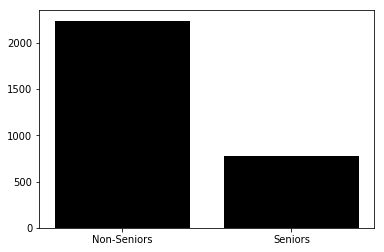

In [20]:
num_seniors = data[mask]['standwt'].count()
num_other = data[~ mask]['standwt'].count()

plt.bar([0,1],
        [num_seniors,num_other][::-1],
        tick_label=['Seniors','Non-Seniors'][::-1],
        color="black")

print("Non-Seniors: {}".format(num_other))
print("Seniors: {}".format(num_seniors))
print("Seniors are {} / 1 of the total sample".format(num_seniors/(num_other+num_seniors)))

plt.show()

###### In order to explore categorical difference, we created a huge set of maps for the question titles and responses.

In [21]:
well_map = {1:'Very Well',2:'Somewhat Well',3:'Not too well',4:'Not at all well'}
q4_map = {1:'A lot',2:'Some',3:'Not too much',4:'Not at all'}
q5_map = {1:'Not Often',2:'Occassional',3:'Frequently'}
q8_map = {1:'Useful',2:'Stressful'}
yn_map = {1:'Yes',2:'No'}
num_map = {1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7'}

cat_value_maps = {
    'live1':{1:'Urban',2:'Suburb',3:'Town',4:'Rural'},
    'sex':{1:'Male',2:'Female'},
    'marital':{1:'Married',2:'Partner',3:'Divorce',
               4:'Separated',5:'Widowed',6:'Single'},
    'par':yn_map,
    'educ2':{1:'< h_school',2:'hs_inc',3:'hs_grad',4:'col_inc',5:'col_2yr',6:'col_4yr',7:'grad_inc',8:'grad'},
    'emplnw':{1:'full_time',2:'part_time',3:'retired',4:'unemployed',5:'self_emp',6:'disabled',7:'student'},
    'disa':yn_map,
    'race3m1':{1:'White',2:'Black',3:'Asian',4:'Other',5:'Native_Am',6:'Pacific_Isl',7:'Hispanic'},
    'party':{1:'Republican',2:'Democrat',3:'Independent',4:'No_Pref',5:'Other'},
    'ideo':{1:'Very Con',2:'Con',3:'Moderate',4:'Lib',5:'Very Lib'},
    'hh1':num_map,
    'q2a':well_map,
    'q2b':well_map,
    'q2c':well_map,
    'q2d':well_map,
    'q2e':well_map,
    'q3a':yn_map,
    'q3b':yn_map,
    'q3c':yn_map,
    'q3d':yn_map,
    'q3e':yn_map,
    'q3f':yn_map,
    'q4a':q4_map,
    'q4b':q4_map,
    'q4c':q4_map,
    'q4d':q4_map,
    'q4e':q4_map,
    'q4f':q4_map,
    'q4g':q4_map,
    'q5':q5_map,
    'q7a':well_map,
    'q7b':well_map,
    'q7c':well_map,
    'q7d':well_map,
    'q8':q8_map,
    'eminuse':yn_map,
    'intmob':yn_map,
    'home3nw':yn_map,
    'bbhome1':{1:'Dial-up',2:'High-speed',3:'Both',4:'Mobile Only',5:'None'},
    'bbhome2':yn_map,
    'device1a':yn_map,
    'device1b':yn_map,
    'device1c':yn_map,
    'device1d':yn_map,
    'smart1':yn_map,
    'smart2':yn_map,
    'snsint2':yn_map,
    'devicehha':num_map,
    'devicehhb':num_map,
    'devicehhc':num_map,
    'devicehhd':num_map,
    }
cat_title_map = {
    'live1':'Location',
    'par':'Currently Parenting',
    'educ2':'Education',
    'emplnw':'Employment',
    'disa':'Disability',
    'inc':'Income',
    'race3m1':'Race',
    'ideo':'Idealogy',
    'hh1':'Household Members',
    'q2a':'Intelligence Fixed',
    'q2b':'Music Talent Non-fixed',
    'q2c':'Hard Work Instrumental',
    'q2d':'Intelligence > Hard Work',
    'q2e':'People Fixed',
    'q3a':'Novelty Stressful',
    'q3b':'Feedback Appreciated',
    'q3c':'Opposing Data Considered',
    'q3d':'Information Sought',
    'q3e':'Beliefs Fixed',
    'q3f':'Novelty Adapted To',
    'q4a':'More Computer Training Helpful',
    'q4b':'More Info-savvy Friends Helpful',
    'q4c':'More Reliable Net Service Helpful',
    'q4d':'Unlimited Data Plan Helpful',
    'q4e':'Closer Library Helpful',
    'q4f':'More Library Hours Helpful',
    'q4g':'Reliable Info Training Helpful',
    'q5':'Need Help Getting Info Online',
    'q7a':'Multi-tasker',
    'q7b':'Easy to Relax',
    'q7c':'Current Life Pace Harmful',
    'q7d':'Usually Patient in Queue',
    'q8':'Information Availability Useful/Stressful',
    'eminuse':'Email/Net Use',
    'intmob':'Mobile Net Use',
    'home3nw':'Home Net Use',
    'bbhome1':'Has Broadband',
    'bbhome2':'Dial-up Check',
    'device1a':'Has Cellphone',
    'device1b':'Has E-Reader',
    'device1c':'Has Tablet',
    'device1d':'Has Desktop/Laptop',
    'smart1':'Has Smartphone',
    'smart2':'Has Smartphone 2',
    'snsint2':'Uses Social Media',
    'devicehha':"Household # Smartphones",
    'devicehhb':"Household # Tablets",
    'devicehhc':"Household # Computers",
    'devicehhd':"Household # Streaming Device",
}
demo_categoricals = ['live1','sex','marital','par','educ2','emplnw','disa','race3m1','party','ideo','hh1']
q2_categoricals = ['q2a','q2b','q2c','q2d','q2e']
q3_categoricals = ['q3a','q3b','q3c','q3d','q3e','q3f']
tech_categoricals = ['eminuse','intmob','home3nw','bbhome1','bbhome2','device1a','device1b','device1c',
    'device1d','smart1','smart2','snsint2','devicehha','devicehhb','devicehhc','devicehhd']
test_categoricals = ['devicehha']
ttc_categoricals = ['q4a','q4b','q4c','q4d','q4e','q4f','q4g','q5','q7a','q7b','q7c','q7d','q8']

###### We also created a function for creating boostrap estimates of variance and side-by-side comparisons using the sampling weights for categorical reponses.

In [22]:
#Thanks to https://stackoverflow.com/questions/45718750/how-to-add-error-bars-to-a-bar-plot-in-matplotlib-by-specifying-a-lower-and-uppe

def cat_compare_closer(data,mask,categoricals,cat_value_maps,cat_title_map):
    '''
    Compare each categorical response with side-by-side bars
    Whose height is the mean of bootstrap sub-samples of equal size 
    and error bars are equal to the 95% confidence interval for the mean.
    '''
    for c in categoricals:
        
        # Create a mask to remove non-responders
        nr_mask = data[c] < 8
        
        #set ticks
        width = 0.40
        ticks = np.array(list(cat_value_maps[c].keys()))+(width/2)
        tick_labels = list(cat_value_maps[c].values())
        
        #Map title variable to appropriate word if designated in map.
        title_var = cat_title_map.get(c) or c.capitalize()

        #Perform the bootstrap
        grps_s = []
        grps_g = []
        samples = 1000
        n = 500

        for i in range(samples):
            sample_s = data[nr_mask & mask].sample(n,replace=True)
            sample_g = data[nr_mask & (~ mask)].sample(n,replace=True)
            grps_s.append(sample_s.groupby(by=c)['senwt'].sum())
            grps_g.append(sample_g.groupby(by=c)['senwt'].sum())

        m_s = np.mean(grps_s,axis=0)
        conf_s = np.std(grps_s,axis=0)*1.96
        m_g = np.mean(grps_g,axis=0)
        conf_g = np.std(grps_g,axis=0)*1.96

        f, ax = plt.subplots(1,1,figsize=(8,4))

        ind = np.arange(1,len(m_g)+1)
        if(len(m_s) < len(m_g)):
            for i in range(len(m_g)-len(m_s)):
                m_s = np.append(m_s,0)
                conf_s = np.append(conf_s,0)
        
        rects1 = ax.bar(x=ind,height=m_s,width=width,yerr=conf_s,color='blue')
        rects2 = ax.bar(x=ind+width,height=m_g,width=width,yerr=conf_g,color='red')
        ax.set_title('{} Distribution for n={}'.format(title_var,str(n)))
        ax.set_xlabel(title_var)
        ax.set_ylabel('Number of People')
        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels,rotation=45)
        ax.legend((rects1[0], rects2[0]), ('Seniors', 'Non Seniors'))

        plt.show()

Several of these categorical comparisons are included in the report.

Here is an example for fun.


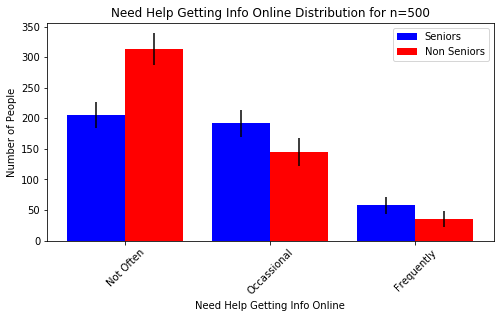

In [23]:
#cat_compare_closer(data,mask,demo_categoricals,cat_value_maps,cat_title_map)
#cat_compare_closer(data,mask,q2_categoricals,cat_value_maps,cat_title_map)
#cat_compare_closer(data,mask,tech_categoricals,cat_value_maps,cat_title_map)
cat_compare_closer(data,mask,['q5'],cat_value_maps,cat_title_map)

## Thus Concludes the Methodology Notebook.